Before you turn this problem in, make sure everything runs as expected. First, **restart the kernel** (in the menubar, select Kernel$\rightarrow$Restart) and then **run all cells** (in the menubar, select Cell$\rightarrow$Run All).

Make sure you fill in any place that says `YOUR CODE HERE` or "YOUR ANSWER HERE", as well as your name and collaborators below:

In [1]:
NAME = "Alejandro Puerto Castro"
COLLABORATORS = "Gonzalo Peraza"

---

In [2]:
import utils
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

## The Gaussian Mixture Model

As a generative model for the data, consider the case of $k$ clusters, each with a probability density. A data point is generated as follows:
1. Uniformly sample a random cluster $z \in \{1,2,\ldots,k\}$.
2. Sample a point from the distribution for cluster $z$, $\mathcal{N}(X|\mu_z,\Sigma_z)$.

Let's define the following:
- Cluster probabilities: $\pi = (\pi_1,\ldots,\pi_k)$
- Cluster means: $\mu = (\mu_1,\ldots,\mu_k)$
- Cluster covariance matrices: $\Sigma = (\Sigma_1,\ldots,\Sigma_k)$

The joint density distribution can be factorized as
$$
p(x, z) = p(z)p(x|z)=\pi_z\mathcal{N}(x|mu_z, \Sigma_z)
$$
where $\pi_z$ is the probability of choosing cluster $z$, and $z$ is the true cluster assignment of $x$, i.e., $x$ belongs to the $z$ cluster. If we were to know the parameters $\pi_z$, $\mu_z$, and $\Sigma_z$, then evaluating $p(x,z)$ is trivial.

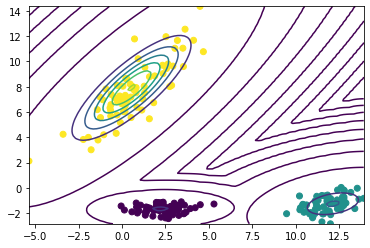

In [3]:
# Example: Generative Gaussian mixture with K=3.

# Create 3 2D cov matrices and 3 mean vectors.
np.random.seed(5)
mu = np.random.normal(0, 5, size=(3,2))
cov = []
for i in range(3):
    A = np.random.normal(0, 1, size=(2,2))
    cov.append(abs(A @ A.T))
    
# Sample points
X = []
Z = []
for i in range(200):
    Z.append(np.random.randint(0, 3))
    X.append(np.random.multivariate_normal(mu[Z[i]], cov[Z[i]]))
X = np.array(X)    
plt.scatter(X[:,0], X[:,1], c=Z)

# Plot probability contours
def prob(x1, x2):
    x = np.array([x1, x2])
    p = 0
    for i in range(3):
        p += (1/3 * (1/(2*np.pi)*np.sqrt(np.linalg.det(cov[i]))) *
                    np.exp(-0.5 * (x-mu[i]) @ np.linalg.inv(cov[i]) @ (x-mu[i])))
    return p

x_vals = np.linspace(X[:,0].min(), X[:,0].max(), 100)
y_vals = np.linspace(X[:,1].min(), X[:,1].max(), 100)
XG, YG = np.meshgrid(x_vals, y_vals)
P = np.zeros((len(x_vals), len(y_vals)))
for i in range(len(XG[0])):
    for j in range(len(YG[0])):
        P[i,j] = prob(XG[i,j], YG[i,j])
plt.contour(XG, YG, P, np.geomspace(P.min(), P.max(), 10))
plt.contour(XG, YG, P)

Unfortunately, what we are trying to obtain are precisely the parameters. In particular, as our interest is clustering, we are interested in estimating the hidden variables $z_i$ for observed data points $x_i$. We actually need the condition probability:
$$
p(z|x) = \frac{p(x,z)}{p(x)}
$$
Unlike K-means, the conditional distribution is a soft assignment to clusters, meaning that now we have a probability for $x$ belonging to each of the possible clusters. We can recover a hard assignment with:
$$
z^* = \underset{z \in \{1,\ldots,k\}}{\arg\max} p(z|x),
$$
thus generating a clustered partition, as in K-means.

The required marginal distribution $p(x)$ is obtained as:
$$
p(x) = \sum_{z=1}^k p(x,z) = \sum_{z=1}^k \pi_z\mathcal{N}(x|\mu_z,\Sigma_z),
$$
which is called a mixture distribution or a mixture model. In fact, any convex combination of probability densities is a mixture model:
$$
p(x) = \sum_{z=1}^k w_i p_i(x),
$$
with $w_i\geq 0$ and $\sum_{z=1}^k w_i = 1$.

## Learning in a GMM

Problem: Given data $X$, estimate $\mu$, $\pi$, and $\Sigma$. Once the parameters have been estimated, clustering is a matter of evaluating $p(z|x)$ given above.

One solution seeks the Maximum Likelihood Estimator (MLE) of the parameters. The likelihood for a GMM with $n$ observations $x_i$ is:
$$
\mathcal{L}(\pi, \mu, \Sigma) = 
\prod_{i=1}^n \sum_{z=1}^k \pi_z\mathcal{N}(x_i|\mu_z,\Sigma_z)
$$
and the log-likelihood is
$$
J(\pi, \mu, \Sigma) = \log(\mathcal{L}(\pi, \mu, \Sigma)) = 
\sum_{i=1}^n \log \left ( \sum_{z=1}^k \pi_z\mathcal{N}(x_i|\mu_z,\Sigma_z)\right )
$$

Unlike for a single multivariate Gaussian, this log-likelihood is impossible to optimize analytically. Let's remember the log-likelihood of a single multivariate Gaussian:
$$
J(\mu, \Sigma) = -\frac{n}{2}\log|2\pi\Sigma| 
- \frac{1}{2}\sum_{i=1}^n(x_i-\mu)^T\Sigma^{-1}(x_i-\mu),
$$
where the log cancels the exponential in the Gaussian density. While, for a GMM, we have:
$$
J(\pi, \mu, \Sigma) = \sum_{i=1}^n \log 
\left \{ 
\sum_{z=1}^k
\frac{\pi_z}{\sqrt{|2\pi\Sigma_z|}}
\exp \left(
-\frac{1}{2}(x-\mu_z)^T\Sigma_z^{-1}(x_mu_z)
\right )
\right \},
$$
where the sum inside the log prevents this cancellation and no closed form expression for the MLE exists.

### The MLE for Gaussian Models

Before deriving the EM algorithm for GMM, let's build intuition by remembering the MLE for a single Gaussian. For a Gaussian model, the log-likelihood is:
$$
\sum_{i=1}^n \log\mathcal{N}(x_i|\mu,\Sigma) 
= -\frac{nd}{2}\log(2\pi) - \frac{n}{2}\log |\Sigma| - \frac{1}{2}\sum_{i=1}^n (x_i-\mu)^T\Sigma^{-1}(x_i-\mu).
$$

Equating the gradient to zero, we find:
$$
\begin{align}
\mu_{MLE} =& \frac{1}{n}\sum_{i=1}^n x_i\\
\Sigma_{MLE} =& \frac{1}{n}\sum_{i=1}^n(x_i-\mu_{MLE})(x_i-\mu_{MLE})^T.
\end{align}
$$
So, for GMM, if we knew the cluster assignment $z_i$ for each $x_i$, we could compute the MLEs for each cluster as stand alone Gaussians. This is, if the hidden variables $z_i$ were actually observed as well, $(x_1, z_1),\ldots,(x_n, z_n)$:
$$
\begin{align}
n_z =& \sum_{i=1}^n \delta(z_i=z)\\
\hat\pi(z) =& \frac{n_z}{n}\\
\hat\mu_z =&  \frac{1}{n_z}\sum_{i:z_i=z} x_i\\
\hat\Sigma_z =& \frac{1}{n_z}\sum_{i:z_i=z} (x_i-\hat\mu_z)(x_i-\hat\mu_z)^T.
\end{align}
$$

In the EM algorithm we will modify the equations to handle our evolving **soft
assignments**, which we will call **responsibilities**. The responsibility that cluster $j$ takes for observation $x_i$ is:
$$
\begin{align}
\gamma_i^j =& p(z=j|x=x_i)\\
=& p(z=j, x_i)/p(x_i)\\
=& \frac{\pi_j \mathcal{N}(x_i|\mu_j,\Sigma_j)}{\sum_{c=1}^k \pi_c \mathcal{N}(x_i|\mu_c,\Sigma_c)}.
\end{align}
$$
Then the vector of responsibilities $(\gamma_i^1,\ldots,\gamma_i^k)$ is exactly the soft assignment for $x_i$. Under this soft assignment, the "number" of points assigned to cluster $c$ is:
$$
n_c = \sum_{i=1}^n\gamma_i^c.
$$
One way to think of soft assignments is as a generalization of one-hot encoding, where instead of having a single entry equal to 1, all clusters have shared responsibility for the point.

Then the EM algorithm can be understood from the following two realizations:
1. If we know the parameters $\mu$, $\Sigma$, and $\pi$, then it's easy to find the responsibilities.
2. If we know the (soft) assignments, we can easily find estimates for $\pi$, $\Sigma$, and $\mu$.

The EM algorithm for GMM then iterates through both steps:
1. Initialize the parameters $\mu$, $\Sigma$, and $\pi$ (e.g. using k-means).
2. The **Expectation step**: Evaluate the responsibilities (find the expected value of the hidden variables) using the current parameters:
$$
\gamma_i^j = p(z=j|x=x_i) = \frac{\pi_j \mathcal{N}(x_i|\mu_j,\Sigma_j)}{\sum_{c=1}^k \pi_c \mathcal{N}(x_i|\mu_c,\Sigma_c)}
$$
3. The **Maximization** step. Find the MLE for the current partition given by the soft assignments:
$$
\begin{align}
\mu_c^{new} =& \frac{1}{n_c}\sum_{i=1}^n\gamma_i^c x_i\\
\Sigma_c^{new} =& \frac{1}{n_c}\sum_{i=1}^n\gamma_i^c (x_i - \mu_c^{new})(x_i - \mu_c^{new})^T\\
\pi_c^{new} =& \frac{n_c}{n}
\end{align}
$$
4. Repeat steps 2 and 3 until the log-likelihood converges.

### Implementing the EM algorithm for GMM

In the following exercise you'll implement both steps of the EM algorithm for GMM and then test your implementation against a sample data set.

First, we need to initialize parameters for the Gaussian clusters, a good method is to employ K-means as an initialization algorithm. The following function uses the sklearn implementation of K-means to find initial values for $\mu$, $\Sigma$, and $\pi$.

In [4]:
from sklearn.cluster import KMeans

def gmm_init_params(X, K):
    n, d = X.shape
    
    kmeans = KMeans(n_clusters=K, random_state=0).fit(X)
        
    mu = kmeans.cluster_centers_
    
    sigma = np.zeros((K, d, d))
    pi = np.zeros(K)
    for k in range(K):
        Xk = X[kmeans.labels_ == k]
        Xc = Xk - mu[k][None,:]
        nk = len(Xc)
        sigma[k] = Xc.T @ Xc / nk
        pi[k] = nk/n
    
    return mu, sigma, pi

To test our functions, lets use the Iris data set:

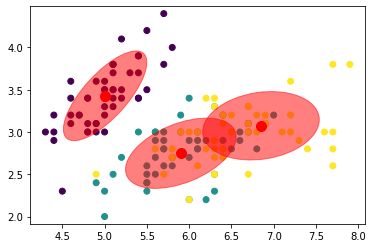

In [5]:
from sklearn import datasets

iris = datasets.load_iris()
X = iris.data
y = iris.target

K = 3

mu, sigma, pi = gmm_init_params(X, K)

# Visualize centers and estiated cov
fig, ax = plt.subplots(1,1)
ax.scatter(X[:,0], X[:,1], c=y)
ax.scatter(mu[:,0], mu[:,1], c='r', s=100);
utils.plot_ellipses(mu, sigma, ax)

The following function implements the E step of the algorithm, for the multivariate Gaussian pdf we'll use scipy's implementation. Refer to the documentation for details on how to use such function.

In [6]:
from scipy.stats import multivariate_normal as G

In [7]:
def gmm_e_step(X, K, mu, sigma, pi):
    """ Finds the cluster respnsibilities for each data point. 
    
    Inputs:
        - X: data matrix (n x d)
        - K: int, number of clusters
        - mu: array of mean vectors for each cluster (K x d)
        - sigma: tensor of covariance matrices (K x d x d) where sigma[i] 
                 is the cov matrix of cluster i
        - pi: array of cluster probabilities p(z=k), of length K
    Outputs:
        - r: array of responsibilities, (n x k)"""
    
    # Find each responibility p(z_i = k | x_i)
    # You must return the following values correctly
    n, d = X.shape
    r = np.zeros((n, K))
    
    # Intialize the array of gaussian densities for all points.
    # This should be a numpy array of shape (n x k) with p(xi|z=k)
    # as entries.
    gauss_prob = np.zeros((n,K))
    # YOUR CODE HERE
    for k in range(K):
        gauss_prob[:,k] = G.pdf(X, mu[k], sigma[k]) #probability density function
    #raise NotImplementedError()
    
    # Multiply by pi_z
    # YOUR CODE HERE
    prob = gauss_prob * pi[None, :]
    #raise NotImplementedError()
    
    # Normalize by dividing by the marginal p(x)
    # YOUR CODE HERE
    marginal = np.sum(prob, axis=1)
    responsibilities = prob / marginal[:, None]
    r = responsibilities
    #raise NotImplementedError()
    
    return r

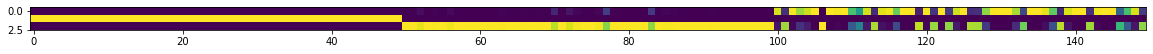

In [8]:
r = gmm_e_step(X, K, mu, sigma, pi)
fig, ax = plt.subplots(figsize = (20,20))
# Visualize soft assignments for the 3 clusters, color indicates p(z|x).
im = ax.imshow(r.T)

Now, implement the Maximization step by finding the MLE estimators keeping the soft assignments constant:

In [9]:
def gmm_m_step(X, K, r):
    """ Finds the parameters mu, sigma, pi for a given soft assigment r. 
    
    Inputs:
        - X: data matrix (n x d)
        - K: int, number of clusters
        - r: soft assignment matrix (n x K), each entry r_ij is the cluster j responsibility 
        for observation i
    Outputs:
        - mu: array of mean vectors for each cluster (K x d)
        - sigma: tensor of covariance matrices (K x d x d) where sigma[i] 
                 is the cov matrix of cluster i
        - pi: array of cluster probabilities p(z=k), of length K
    """
    
    n, d = X.shape
    
    # You must return the following values correctly
    mu = np.zeros((K, d))
    sigma = np.zeros((K,d,d))
    pi = np.zeros(K)
    
    # YOUR CODE HERE
    
    nc = np.sum(r, axis=0) #number of points assigned to cluster -> nc
    for k in range(K):
        mu[k] = np.sum((r[:,k][:,None] * X), axis=0) / nc[k] #mean vectors for each cluster
        X_centroid = (X - mu[k][None,:]) * np.sqrt(r[:,k][:,None]) 
        sigma[k] = X_centroid.T @ X_centroid/ nc[k]
    pi = nc/n
    #raise NotImplementedError()
    
    return mu, sigma, pi

For the converging condition we need en expression for the log-likelihood:

In [10]:
def gmm_likelihood(X, mu, sigma, pi):
    """ The log-likelihood function for GMM.
    Inputs:
        - X: data matrix (n x d)
        - K: int, number of clusters
        - mu: array of mean vectors for each cluster (K x d)
        - sigma: tensor of covariance matrices (K x d x d) where sigma[i] 
                 is the cov matrix of cluster i
        - pi: array of cluster probabilities p(z=k), of length K
    Outputs:
        - L: value of the log-likelihood
    """
    
    L = 0
    K = len(mu)
    n = len(X)
    
    # YOUR CODE HERE
    for i in range(n):
        likelihood = 0
        for k in range(K):
            likelihood += pi[k]/np.sqrt(2*np.pi*np.linalg.det(sigma[k]))*np.exp(-0.5*(X[i] -  mu[k]) @ np.linalg.inv(sigma[k]) @ (X[i] -  mu[k]))
        L += np.log(likelihood)
    #raise NotImplementedError()
    
    return L  

In [11]:
L = gmm_likelihood(X, mu, sigma, pi)
print(f'Log-likelihood at this step is: {L:0.2f}')
print('You should see a value arroung: 216.20')

Log-likelihood at this step is: 216.20
You should see a value arroung: 216.20


The full EM algorithm is then:

In [12]:
def gmm_em(X, K, tol=0.001, max_iters=100):
    
    mu, sigma, pi = gmm_init_params(X, K)
    
    n_iters = 0
    L = gmm_likelihood(X, mu, sigma, pi)
    
    for i in range(max_iters):
        n_iters += 1
        L_old = L
        
        r = gmm_e_step(X, K, mu, sigma, pi)
        
        mu, sigma, pi = gmm_m_step(X, K, r)
    
        L = gmm_likelihood(X, mu, sigma, pi)
        if abs(L - L_old) < tol:
            break
        
        
    return mu, sigma, pi, n_iters

Run for a total of 20 interations.
Log-likelihood at this step is: 233.34
You should see a value arroung: 233.34


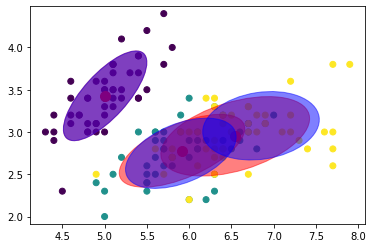

In [13]:
mu_old, sigma_old, pi_old = mu, sigma, pi
mu, sigma, pi, n_iters = gmm_em(X, K)
print(f'Run for a total of {n_iters} interations.')
# Visualize centers and estiated cov
fig, ax = plt.subplots(1,1)
ax.scatter(X[:,0], X[:,1], c=y)
ax.scatter(mu[:,0], mu[:,1], c='r', s=100);
utils.plot_ellipses(mu, sigma, ax)
utils.plot_ellipses(mu_old, sigma_old, ax, color='blue')

L = gmm_likelihood(X, mu, sigma, pi)
print(f'Log-likelihood at this step is: {L:0.2f}')
print('You should see a value arroung: 233.34')

## The Expectation-Maximization for latent variable models.

The EM algorithm is an iterative process to obtain the ML estimator of latent variable models (we have seen those before, PPCA, FA, ICA). 

## References
- Bishop CH 9
- https://davidrosenberg.github.io/mlcourse/Archive/2018/Lectures/13b.mixture-models.pdf